# A Problem in Light Curve Analysis
Suppose a light curve consists of a train of pulses. The functional form of the pulses is unknown _a priori_. We wish to _characterize the width distribution_ of these pulses and, if possible, separate the signal into contributions with differing pulse width.

## Numerical example
The numerical example below embodies a relatively straightforward version of the above problem. I generate two time series, which I call signals $A$ and $B$.  Signal $A$ consists of many thousands of identical pulses with the same width, but with random height. The distribution of these pulses is random, using a Poisson process, but they are infrequent enough that overlap is rare. Signal $B$ is similar, but has pulses of much greater width. The signal to be analyzed is the sum $A+B$. The results of my analysis below are insensitive to the pulse shape.

In [1]:
# Numerical example

import numpy as np
import peaklets as peaklet
import matplotlib.pyplot as plt
%matplotlib inline

rng = np.random.default_rng()
# A fun distribution, used for generating random pulse heights.
def rand2exp(a=1,b=None,size=1): 
    """
    Random deviates consisting each of the sum of two exponentially
    distributed deviates, 0 < x < ∞. With default parameters, the mode
    of the distribution is unity.
    """
    if (b is None):
        b = a
    return rng.exponential(a,size) + rng.exponential(b,size)

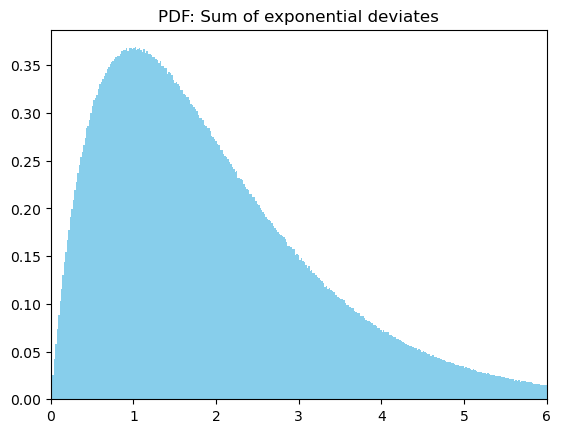

In [31]:
foo = rand2exp(size=10000000)
plt.figure()
plt.hist(foo, 1000, color='skyblue', density=True)
plt.xlim((0,6))
plt.title('PDF: Sum of exponential deviates')
plt.show()

In [3]:
NA = 1024*4096
pperiod1 = 10
xx = np.arange(pperiod1)/pperiod1
pulse1 = 16*(xx * (1 - xx))**2
signalA = np.zeros(NA)
Npulses1 = 4096*4
for i in range(Npulses1):
    x0 = rng.integers(NA - pperiod1)
    signalA[x0:x0+pperiod1] += pulse1*rand2exp()

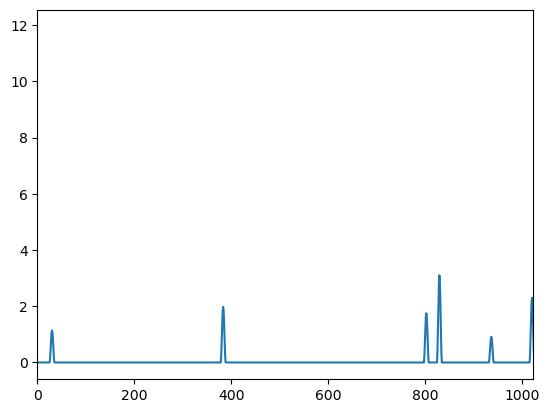

In [4]:
plt.figure()
plt.plot(signalA)
plt.xlim((0,1023))
plt.title()
plt.show()

In [6]:
# Second signal, wider pulses.
NB = NA
pperiod2 = 40
xx = np.arange(pperiod2)/pperiod2
pulse2 = 16*(xx * (1 - xx))**2
signalB = np.zeros((NB))
Npulses2 = 4096
for i in range(Npulses2):
    x0 = rng.integers(NB - pperiod2)
    signalB[x0:x0+pperiod2] += pulse2*rand2exp()

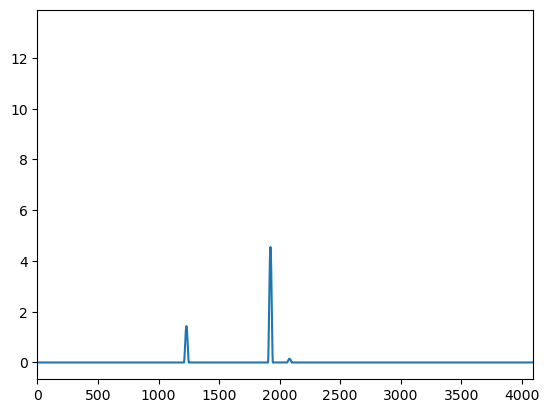

In [17]:
plt.figure()
plt.plot(signalB)
plt.xlim((0,4096))
plt.show()

## Failure of the Fourier approach
The standard tools for signal processing are based on the Fourier transform and its inverse,
$$ \begin{align}
    \tilde{f}(\omega) &\equiv \frac{1}{\sqrt{2}}\int_{-\infty}^{\infty} f(t)\,e^{-i\omega t}\,dt;\\
    f(t) &= \frac{1}{\sqrt{2}}\int_{-\infty}^{\infty} \tilde{f}(\omega)
        \,e^{i\omega t}\,d\omega.
\end{align}$$
To work out a distribution of time or frequency scales, the most natural choice for most practitioners is the power spectrum,
$$
    P(\omega) \equiv \tilde{f}^*(\omega)\,\tilde{f}(\omega) 
        = \left| \tilde{f}(\omega) \right|^2.
$$

There are two basic reasons why the Fourier transform and the associated power spectrum are ill-suited to the problem posed above.
1. Overlap of pulses of differing widths in the Fourier basis. Hence, Fourier filtering is unable to separate the short and long pulses.
1. Lack of physical significance for the power spectrum of a light curve. 

In regard to the last point, a light curve in the astrophysical context is a time series in intensity collected by a telescope over some field of view. The natural (mks) units of intensity are $\mathrm{W\,m^{-2}\,ster^{-1}}$. 

### Comment
Each of the elements of the Fourier basis, save one, have a mean value of zero (the exception is the zero frequency, or DC, basis element). This is a necessary property of any orthogonal basis set. Light curves, however, are intrinsically nonnegative. Consequently, the Fourier transform is an unnatural representation. It fails to localize pulse widths in frequency space, smearing the pulse power over a wide range that begins at the zero frequency and extends to (or beyond) the reciprocal of the pulse width.

One might suppose that wavelet analysis, because of its ability to localize in the time domain, would overcome this limitation. It does not....

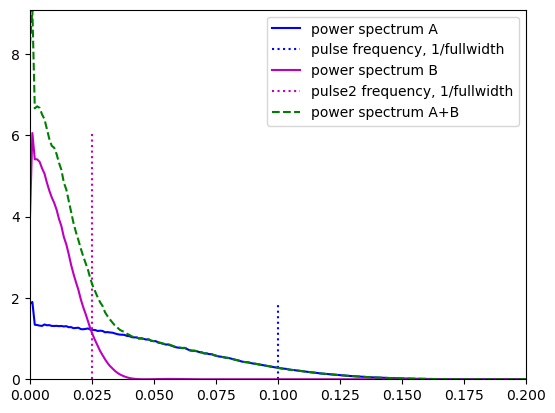

In [27]:
import scipy.signal as sig
fwelch, PwelchA = sig.welch(signalA, nperseg=1024, detrend=False)
_, PwelchB = sig.welch(signalB, nperseg=1024, detrend=False)
_, PwelchSum = sig.welch(signalA + signalB, nperseg=1024, detrend=False)
plt.figure()
plt.plot(fwelch, PwelchA, 'b', label='power spectrum A')
plt.vlines(1/pperiod1, 0, np.amax(PwelchA), 'b', linestyle=':', 
           label=r'pulse frequency, 1/fullwidth')
plt.plot(fwelch, PwelchB, 'm', label='power spectrum B')
plt.vlines(1/pperiod2, 0, np.amax(PwelchB),'m',linestyle=':', 
           label=r'pulse2 frequency, 1/fullwidth')
plt.plot(fwelch, PwelchSum, 'g--', label='power spectrum A+B')
plt.xlim((0,0.2))
plt.ylim((0,np.amax(PwelchSum)))
plt.legend()
plt.show()

## Wavelet approach

## The Peaklet Transform
The purpose of the Peaklet Transform is to interpret a nonnegative time series $f(t)$, such as a light curve, as a superposition of pulses with particular durations. I have chosen the name peaklet to evoke wavelets, because this is a multiscale transform. The wavelet transform uses a mother wavelet function, arbitrarily scaled and translated, to form an overcomplete basis. So, if the mother wavelet function is $\mu$, the time series is represented thus:
$$
    f(t) = \sum_{x,s} w_{x,s} \mu\left[ (t-x)/s \right].
$$
The peaklet transform similarly begins with a scalable function, $\varpi\left[(t+x)/s\right]$, where $s$ is the scale. In the peaklet transform, however, the time series is _not_ represented as a superposition. Instead, scales are filtered from $f(t)$ one at a time, beginning from the largest scale, as follows:
1. Define a range of scales, $s_i = 2^{i/\delta} s_1$, $i=0, i,... N$, where $s_1$ is the next-to-smallest scale, $\delta$ determines the logarithmic spacing, and $N$ is chosen so that $s_N$ is shorter than the time series.
1. Initialize the residual function, $\rho(t):=f(t)$, and $i:=N$.
1. For scale $s_i$, at each time $t$, find the optimal lag $x_it$ as follows:
$$
    x_t = \arg\min_x \frac{f(t+x)}{\varpi(x/s_i)}
$$
1. The peaklet transform at scale $i$ and time $t$ is then __(IS THIS CORRECT?)__
$$
    \tau_i(t) =  \max_z \left[ \varpi\left( (t-z)/s_i\right) \frac{f(t+x_z)}{\varpi(x_z/s_i)} \right].
$$
1. The residual is now $\rho(t) := \rho(t) - \tau_{i}(t)$. Conceptually, this corresponds 
1. If $i>1$, decrement $i$ and return to step 3.
1. The smallest scale, $s_0$, takes up what's left: $\tau_0(t) = \rho(t) $. 

### Inverse
The inverse peaklet transform is simply
$$
    f(t) = \sum_i \tau_i(t).
$$



_The remainder of this notebook provides some demonstrations of the discrete Peaklet Transform._

## A simple dataset

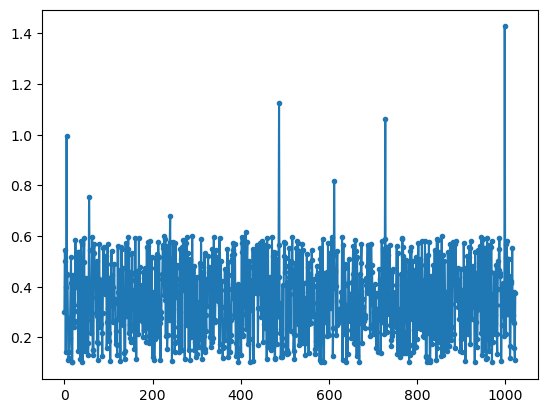

In [9]:
# fake data
Nt = 1024 # number of elements in data array
signal1 = np.random.rand(Nt)**200
#for i in range(8):
#    signal1 += 0.5*(np.roll(signal1, 1) + np.roll(signal1, -1))
signal1 += 0.1 + 0.5*np.random.rand(Nt)  # add some noisy background.
plt.figure()
plt.plot(signal1,'.-')
plt.show()

In [10]:
# Do the transform
pk = peaklet.pkxform(signal1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


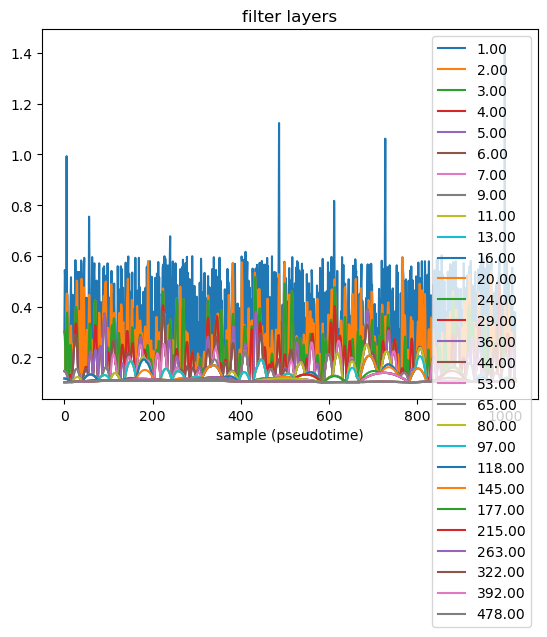

In [11]:
# Plot the filter layers.
Nsc = len(pk.scales)
plt.figure()
plt.title('filter layers')
for i in range(Nsc):
    labeltext = "{:.2f}"
    plt.plot(pk.filters[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudotime)')
plt.legend()
plt.show()

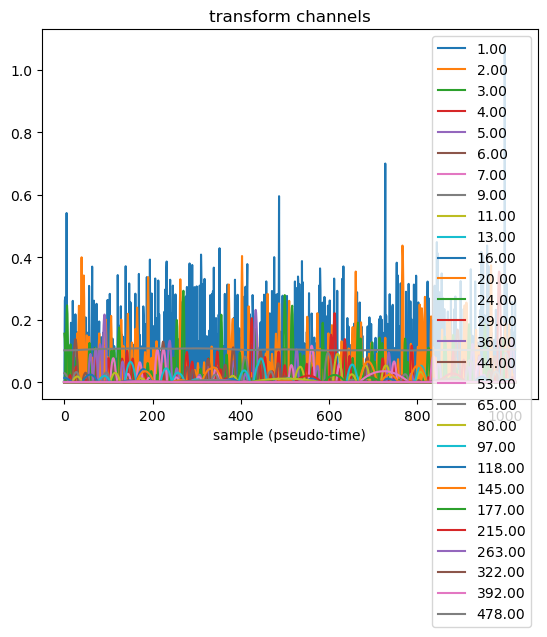

0.0


In [12]:
# plot the transform.
(Ntr,Nt) = pk.xform.shape
plt.figure()
plt.title('transform channels')
for i in range(Ntr):
    labeltext = "{:.2f}"
    plt.plot(pk.xform[i,:],label=labeltext.format(pk.scales[i]))
plt.xlabel('sample (pseudo-time)')
plt.legend()
plt.show()
print(np.amin(pk.xform))

In [13]:
def psplot(pkobj,dt=1.0,tunit='samples',punit='counts'):
    """
    Calculate and plot multiscale power spectrum.
    
    pkobj = PeakletXform object
    dt = sample period (default 1)
    tunit = unit of the time (sampling) axis (default 'samples')
    punit = unit of the light curve (default 'counts')
    """
    timescales = pkobj.scales*dt
    ps = np.sum(pkobj.xform,1)
    plt.semilogx(timescales, ps, '-o')
    plt.xlabel('scale ('+tunit+')')
    plt.ylabel('power ('+punit+')')
    return ps, timescales

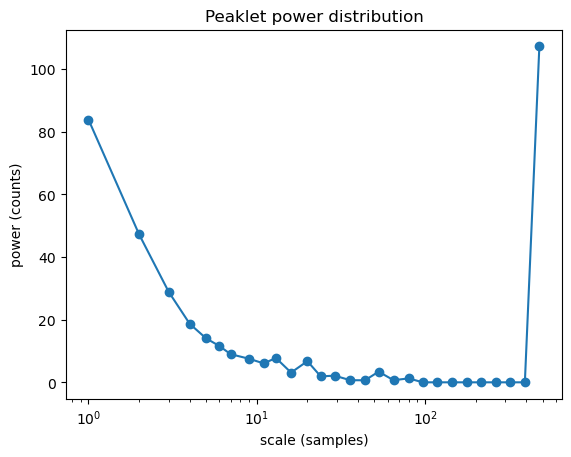

In [14]:
plt.figure()
ps,_ = psplot(pk)
plt.title('Peaklet power distribution');
plt.show()

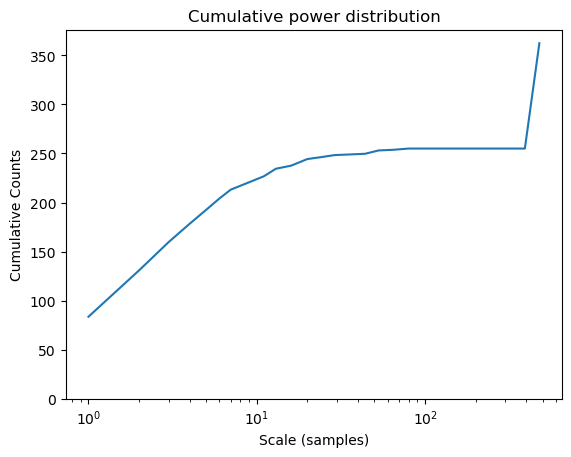

In [15]:
ps_cum = np.cumsum(ps)

plt.figure()
plt.semilogx(pk.scales,ps_cum)
plt.ylim(bottom=0)
plt.title('Cumulative power distribution')
plt.xlabel('Scale (samples)')
plt.ylabel('Cumulative Counts');
plt.show()

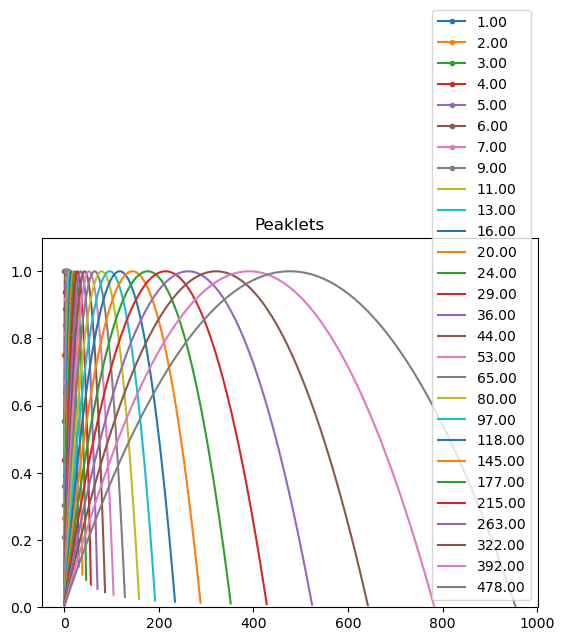

In [16]:
# Plot all the peaklets

plt.figure()
for i in range(Nsc):
    sc = pk.scales[i]
    if sc<10:
        marker='.-'
    else:
        marker='-'
    plt.plot(pk.pklets[i],marker,label=labeltext.format(sc))
plt.title('Peaklets');
plt.ylim((0,1.1))
plt.legend()
plt.show()